In [ ]:
%pip install pandas
%pip install numpy
%pip install sklearn
%pip install matplotlib

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, average_precision_score, confusion_matrix
# How big is train dataset ?
train_test_ratio = 0.039
np.random.RandomState(seed=42)

data_path = os.path.abspath(os.path.join(os.getcwd(), '..',  'dataset'))

names = pd.read_csv(os.path.join(data_path, 'NUSW-NB15_features_v2.csv'))['Name'].tolist()

frames = []

frames.append(pd.read_csv(os.path.join(data_path, "UNSW-NB15_1.csv"), names=names))
# Uncomment to load all csv
frames.append(pd.read_csv(os.path.join(data_path, "UNSW-NB15_2.csv"), names=names))
frames.append(pd.read_csv(os.path.join(data_path, "UNSW-NB15_3.csv"), names=names))
frames.append(pd.read_csv(os.path.join(data_path, "UNSW-NB15_4.csv"), names=names))

df = pd.concat(frames, axis=0, ignore_index=True)

mask = np.random.rand(len(df)) < train_test_ratio
train = df[mask]
test = df[~mask]

# Clear memory
del df

train.head()

C:\Users\Dominik\miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (1,3,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Dominik\miniconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (3,39,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
73,59.166.0.2,62824,149.171.126.7,14455,udp,CON,0.001775,520,304,31,...,0,5,4,5,3,1,1,2,NaN,0
98,59.166.0.6,4318,149.171.126.5,53,udp,CON,0.001112,146,178,31,...,0,12,9,1,2,2,1,1,NaN,0
118,59.166.0.0,28852,149.171.126.3,53,udp,CON,0.001207,132,164,31,...,0,9,9,3,2,2,1,2,NaN,0
132,59.166.0.4,64521,149.171.126.9,53,udp,CON,0.001084,146,178,31,...,0,12,6,2,1,1,1,1,NaN,0
151,59.166.0.8,24521,149.171.126.0,111,udp,CON,0.004458,568,304,31,...,0,4,2,3,3,1,1,2,NaN,0


In [13]:
# Info about data types and columns
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98973 entries, 73 to 2540045
Data columns (total 49 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   srcip             98973 non-null  object 
 1   sport             98973 non-null  object 
 2   dstip             98973 non-null  object 
 3   dsport            98973 non-null  object 
 4   proto             98973 non-null  object 
 5   state             98973 non-null  object 
 6   dur               98973 non-null  float64
 7   sbytes            98973 non-null  int64  
 8   dbytes            98973 non-null  int64  
 9   sttl              98973 non-null  int64  
 10  dttl              98973 non-null  int64  
 11  sloss             98973 non-null  int64  
 12  dloss             98973 non-null  int64  
 13  service           98973 non-null  object 
 14  Sload             98973 non-null  float64
 15  Dload             98973 non-null  float64
 16  Spkts             98973 non-null  int

In [14]:
# Count null values in columns
train.isnull().sum()

srcip                   0
sport                   0
dstip                   0
dsport                  0
proto                   0
state                   0
dur                     0
sbytes                  0
dbytes                  0
sttl                    0
dttl                    0
sloss                   0
dloss                   0
service                 0
Sload                   0
Dload                   0
Spkts                   0
Dpkts                   0
swin                    0
dwin                    0
stcpb                   0
dtcpb                   0
smeansz                 0
dmeansz                 0
trans_depth             0
res_bdy_len             0
Sjit                    0
Djit                    0
Stime                   0
Ltime                   0
Sintpkt                 0
Dintpkt                 0
tcprtt                  0
synack                  0
ackdat                  0
is_sm_ips_ports         0
ct_state_ttl            0
ct_flw_http_mthd    52518
is_ftp_login

In [15]:
# How many attacks and normal records do we have ?
train['Label'].value_counts()

0    86270
1    12703
Name: Label, dtype: int64

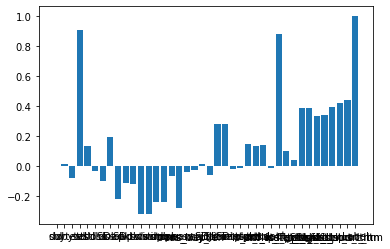

In [16]:
correlation = train.corr()['Label']

plt.bar(correlation.keys(), correlation.tolist())
plt.show()

In [17]:
corr_dict = correlation.to_dict()
correlation_treshold = 0.2

# Return column names where correlation is greater or equal than threshold
column_names = [key for key, value in corr_dict.items() if abs(value) >= correlation_treshold]
column_names.remove('Label')
column_names

['sttl',
 'Dload',
 'swin',
 'dwin',
 'stcpb',
 'dtcpb',
 'dmeansz',
 'Stime',
 'Ltime',
 'ct_state_ttl',
 'ct_srv_src',
 'ct_srv_dst',
 'ct_dst_ltm',
 'ct_src_ ltm',
 'ct_src_dport_ltm',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm']

In [18]:
X_train = train[column_names]
y_train = train['Label']
del train

X_test = test[column_names]
y_test = test['Label']
del test

In [19]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [20]:
y_pred = clf.predict(X_test)

In [21]:
print(f"SVM F1-score: {f1_score(y_test, y_pred)}")
print(f"SVM accuracy: {accuracy_score(y_test, y_pred)}")
print(f"SVM average precision: {average_precision_score(y_test, y_pred)}")

SVM F1-score: 0.9552876779247295
SVM accuracy: 0.988301460750473
SVM average precision: 0.9150528274611811


In [23]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"TP: {tp}")
print(f"TN: {tn}")
print(f"FP: {fp}")
print(f"FN: {fn} <- attacks not detected")

TP: 305063
TN: 2107454
FP: 25040
FN: 3517 <- attacks not detected


# Random forest classifier

In [30]:
from sklearn.ensemble import RandomForestClassifier
clf = make_pipeline(StandardScaler(), RandomForestClassifier())
# clf = RandomForestClassifier()
clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [31]:
y_pred = clf.predict(X_test)
print(f"SVM F1-score: {f1_score(y_test, y_pred)}")
print(f"SVM accuracy: {accuracy_score(y_test, y_pred)}")
print(f"SVM average precision: {average_precision_score(y_test, y_pred)}")

SVM F1-score: 0.9645537079821679
SVM accuracy: 0.9910752398329588
SVM average precision: 0.9353623881170232


In [32]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"TP: {tp}")
print(f"TN: {tn}")
print(f"FP: {fp}")
print(f"FN: {fn} <- attacks not detected")

TP: 296417
TN: 2122871
FP: 9623
FN: 12163 <- attacks not detected


### Random forest has better f1-score than SVM, although for me SVM is better, because it has less FN (not detected attacks)